# **Machine Translation**

Machine translation (MT) in NLP is the process of using computer programs to automatically translate text from a source language to a target language without human intervention.  
It is a subfield of computational linguistics that has seen significant advancements due to deep learning and is now dominated by neural machine translation (NMT) models, which use neural networks to produce more accurate and fluent translations than older methods

In [8]:
# importing libraries

import string
import re

import numpy as np
from numpy import array, argmax, random, take
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers

import matplotlib.pyplot as plt

In [9]:
# loading the data

def read_text(filename):
  with open(filename, 'r') as f:
    text = f.read()
  return text

def to_lines(text):
  sents = text.strip().split('\n')
  sents = [i.split('\t') for i in sents]
  return sents

In [10]:
data = read_text('/content/deu.txt')
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [11]:
print(f"Total number of sentences: {deu_eng.shape[0]}")
print(f"Shape of the data: {deu_eng.shape}")

Total number of sentences: 227080
Shape of the data: (227080, 3)


In [12]:
# considering a sample of 50,000 records for faster training

deu_eng = deu_eng[:50000, :]

In [13]:
# Removing punctuation

deu_eng[:, 0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:, 0]]
deu_eng[:, 1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:, 1]]

In [14]:
# converting to lower case

for i in range(len(deu_eng)):
  deu_eng[i, 0] = deu_eng[i, 0].lower()
  deu_eng[i, 1] = deu_eng[i, 1].lower()

In [15]:
# lengths of strings

eng_len = []
deu_len = []

for i in deu_eng[:, 0]:
  eng_len.append(len(i.split()))

for i in deu_eng[:, 1]:
  deu_len.append(len(i.split()))

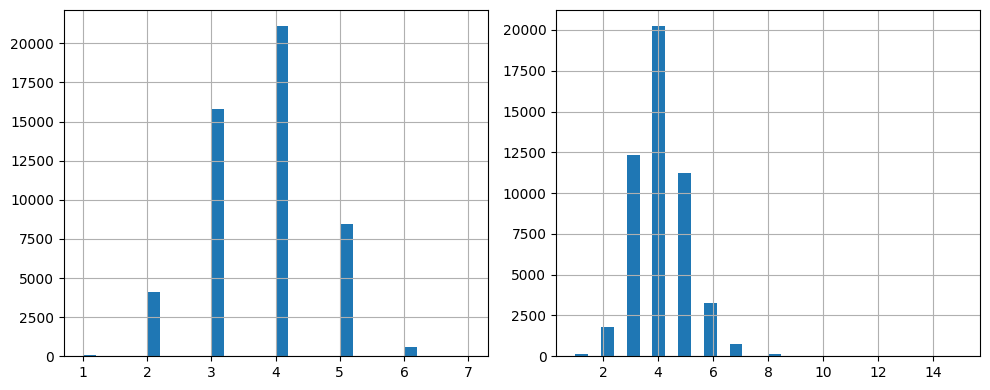

In [16]:
# observing the histogram

eng_len_df = pd.DataFrame(eng_len)
deu_len_df = pd.DataFrame(deu_len)

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.hist(eng_len_df, bins = 30)
plt.grid(True)
plt.subplot(1, 2, 2)
plt.hist(deu_len_df, bins = 30)
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# tokenization

def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [18]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print(f"English Vocabulary Size: {eng_vocab_size}")

English Vocabulary Size: 6256


In [19]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print(f"German Vocabulary Size: {deu_vocab_size}")

German Vocabulary Size: 10329


In [20]:
# encode and padding

def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(seq, maxlen = length, padding = 'post')
  return seq

In [21]:
# train test split

from sklearn.model_selection import train_test_split

train, test = train_test_split(deu_eng, test_size = 0.2, random_state = 42)

In [22]:
# training preparation

trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1]) # german
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0]) # english

# testing preparation

testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1]) # german
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0]) # english

In [23]:
# building the NMT (Neural Machine Translation) model

def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length = in_timesteps, mask_zero = True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences = True))
  model.add(Dense(out_vocab, activation = 'softmax'))
  return model

In [24]:
# model compilation

model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
rms = optimizers.RMSprop()
model.compile(optimizer = rms, loss = 'sparse_categorical_crossentropy')

In [26]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs = 20, batch_size = 512,
                    validation_split = 0.2)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step - loss: 5.7789 - val_loss: 3.1293
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 3.0220 - val_loss: 2.8679
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 2.8386 - val_loss: 2.8065
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 2.7909 - val_loss: 2.7711
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 2.7618 - val_loss: 2.7555
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 2.7421 - val_loss: 2.7642
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - loss: 2.7271 - val_loss: 2.7277
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 2.7054 - val_loss: 2.7187
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 2.6858 - val_loss: 2.6860
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 2.6597 - val_loss: 2.6603
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 2.6321 - val_loss: 2.6469
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14

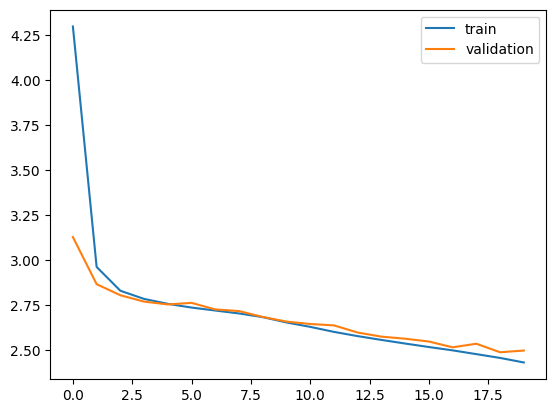

In [27]:
# plotting history


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

In [28]:
# predictions on unseen data

preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


In [29]:
preds = np.argmax(preds, axis = -1)

In [30]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

In [31]:
pred_texts = []
for i in preds[:50]:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], eng_tokenizer)
    if j > 0:
      if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if(t == None):
        temp.append('')
      else:
        temp.append(t)
  pred_texts.append(' '.join(temp))

In [32]:
pred_df = pd.DataFrame({'actual' : test[:50, 0], 'predicted' : pred_texts})

In [33]:
pred_df.head(15)

,actual,predicted
0,go on tom drink it,he is a
1,they struggled,she you
2,hold it,please
3,is tom still up,tom is a
4,you wont die today,we you
5,ive missed you too,i cant to
6,are you curious,we you
7,i really miss my wife,i cant tom
8,its no good,how you
9,the file is corrupt,its is
